In [ ]:

# Step 1: Install required packages
!pip install albumentations opencv-python-headless

In [ ]:
# Step 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 3: Import all necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import albumentations as A
from sklearn.model_selection import train_test_split
import shutil

OIL SPILL IMAGE PREPROCESSING TECHNIQUES

1. RESIZING:
   - All images are resized to 256x256 pixels
   - Maintains aspect ratio with appropriate padding if needed
   - Reduces computational requirements while preserving important features

2. NORMALIZATION:
   - Pixel values are scaled to the range [0, 1]
   - Formula: normalized_pixel = original_pixel / 255.0
   - Helps with model convergence during training

3. DATA AUGMENTATION:
   - Applied to both images and masks simultaneously
   - Techniques include:
     * Random rotation
     * Horizontal and vertical flipping
     * Brightness adjustment
     * Contrast adjustment
   - Masks are augmented consistently with images

4. MASK PROCESSING:
   - RGB masks are converted to binary format
   - Oil spill pixels (RGB: 255,0,124) become 1
   - All other pixels become 0
   - Resized to match image dimensions (256x256)

5. DATA SAVING:
   - Preprocessed images and masks are saved as PNG files
   - Organized in train/val/test directories
 

Processing train masks: 100%|██████████| 811/811 [03:02<00:00,  4.45it/s]


Found 203 masks in val set


Processing val masks: 100%|██████████| 203/203 [00:41<00:00,  4.85it/s]


Found 254 masks in test set


Processing test masks: 100%|██████████| 254/254 [00:54<00:00,  4.70it/s]



Visualizing 3 samples from train set:


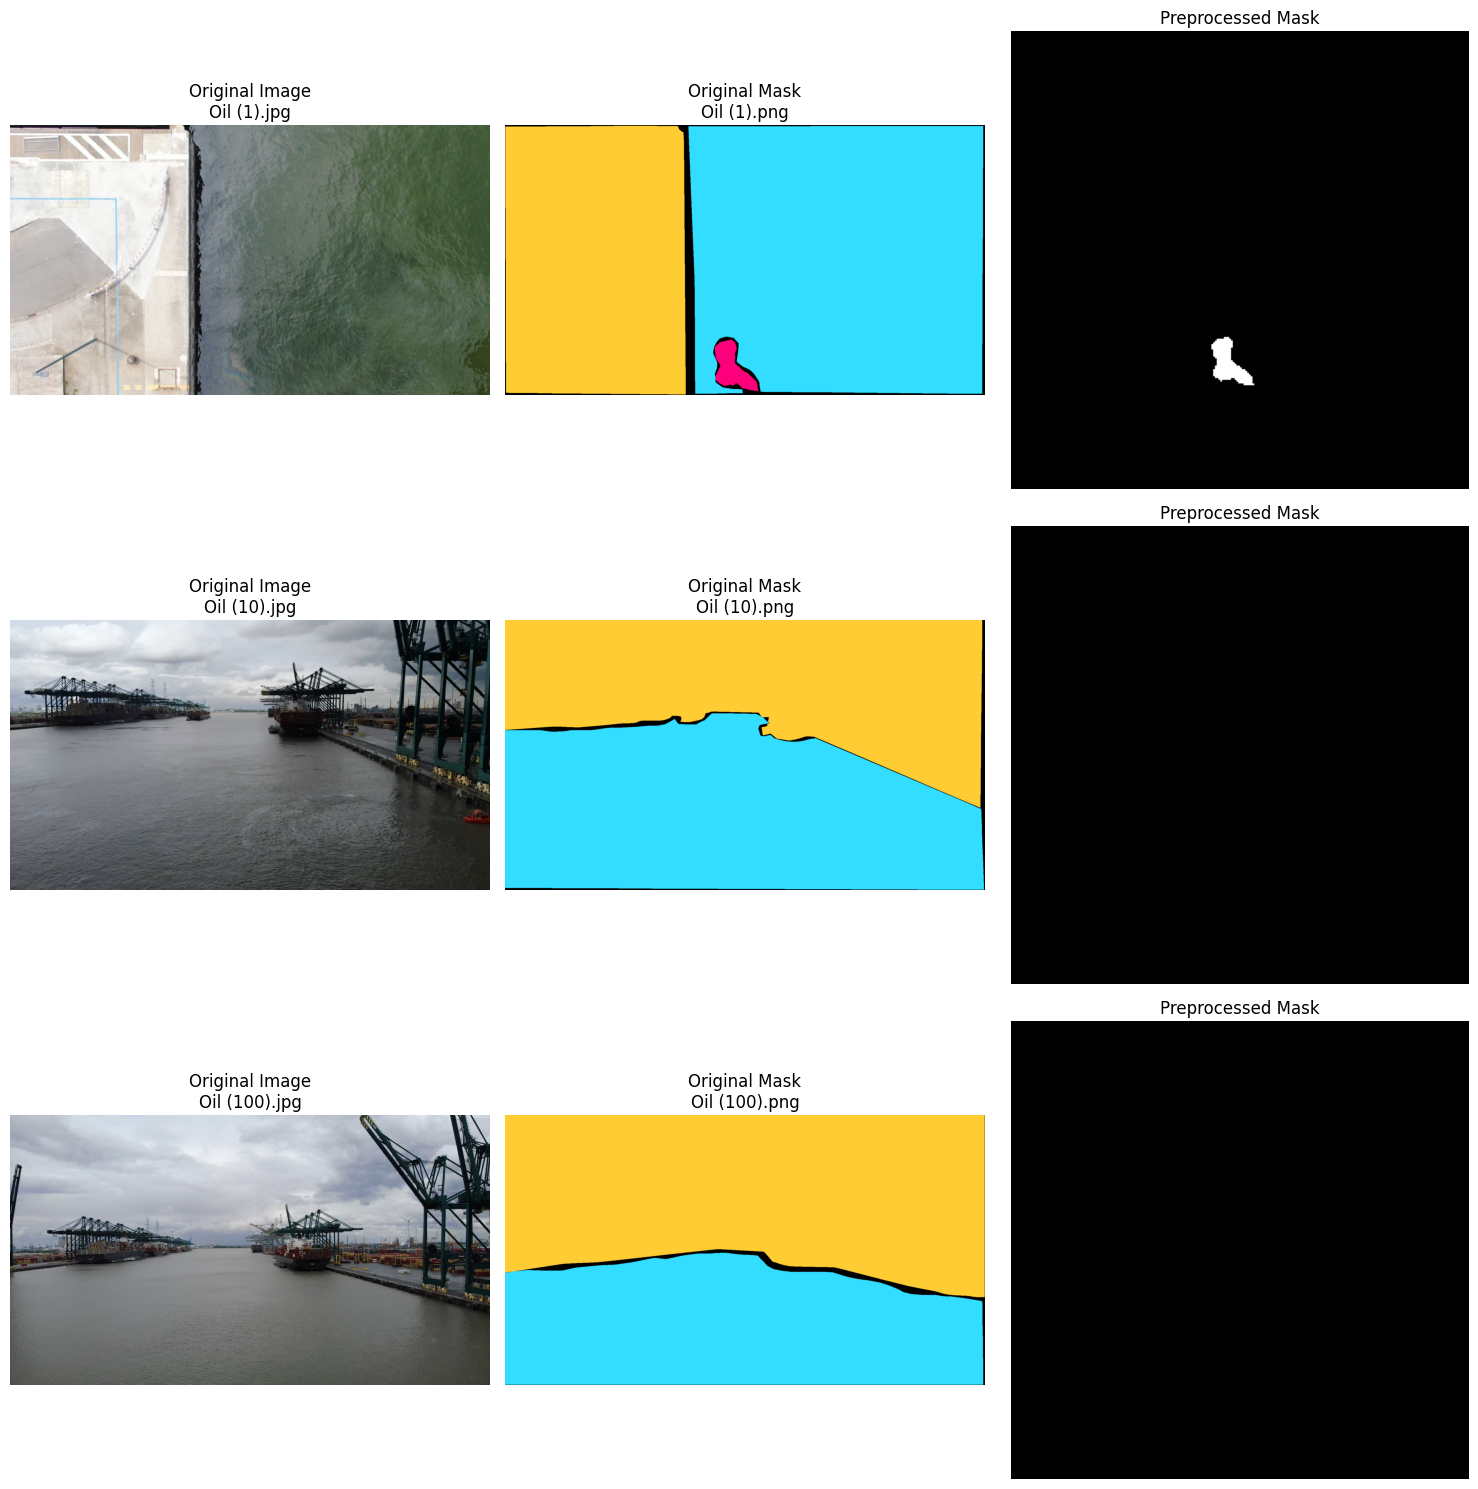


Visualizing 3 samples from val set:


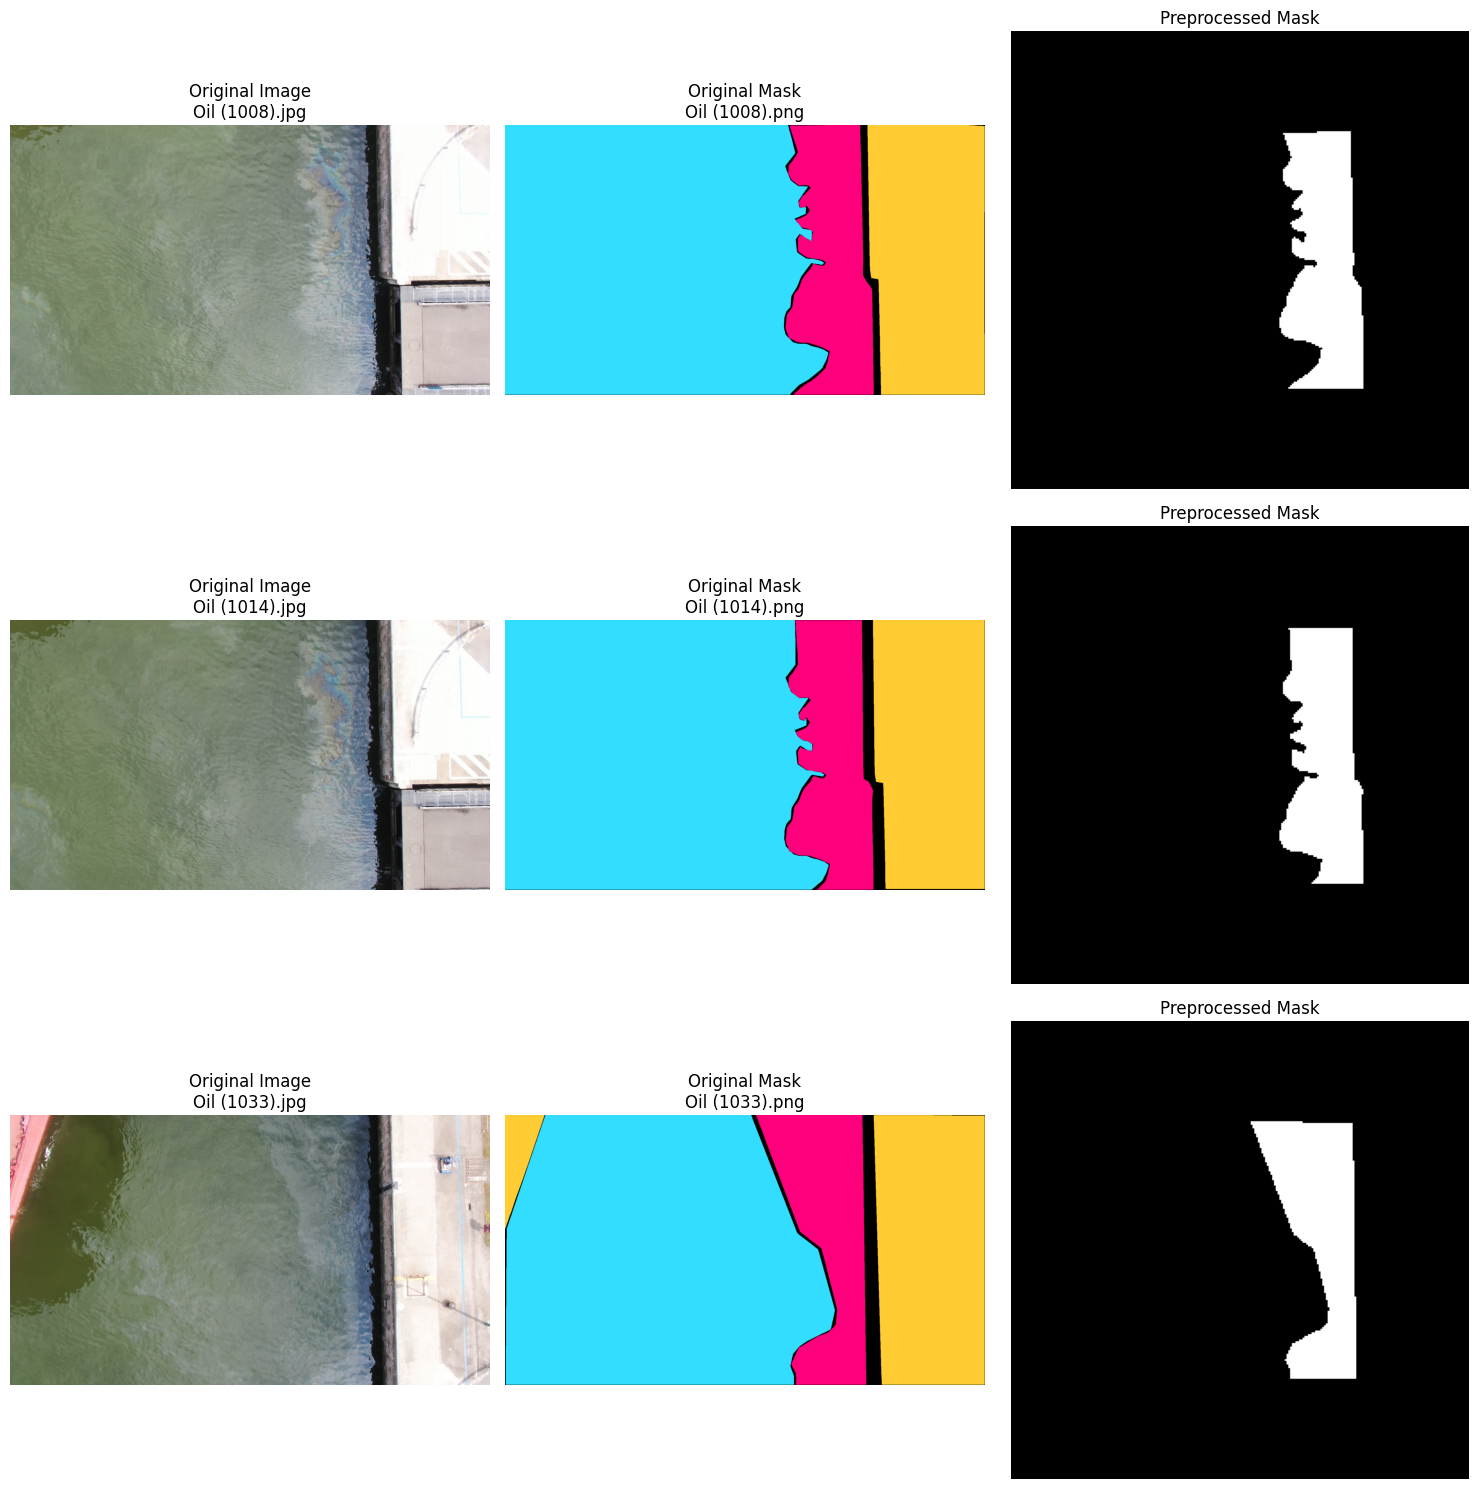


Visualizing 3 samples from test set:


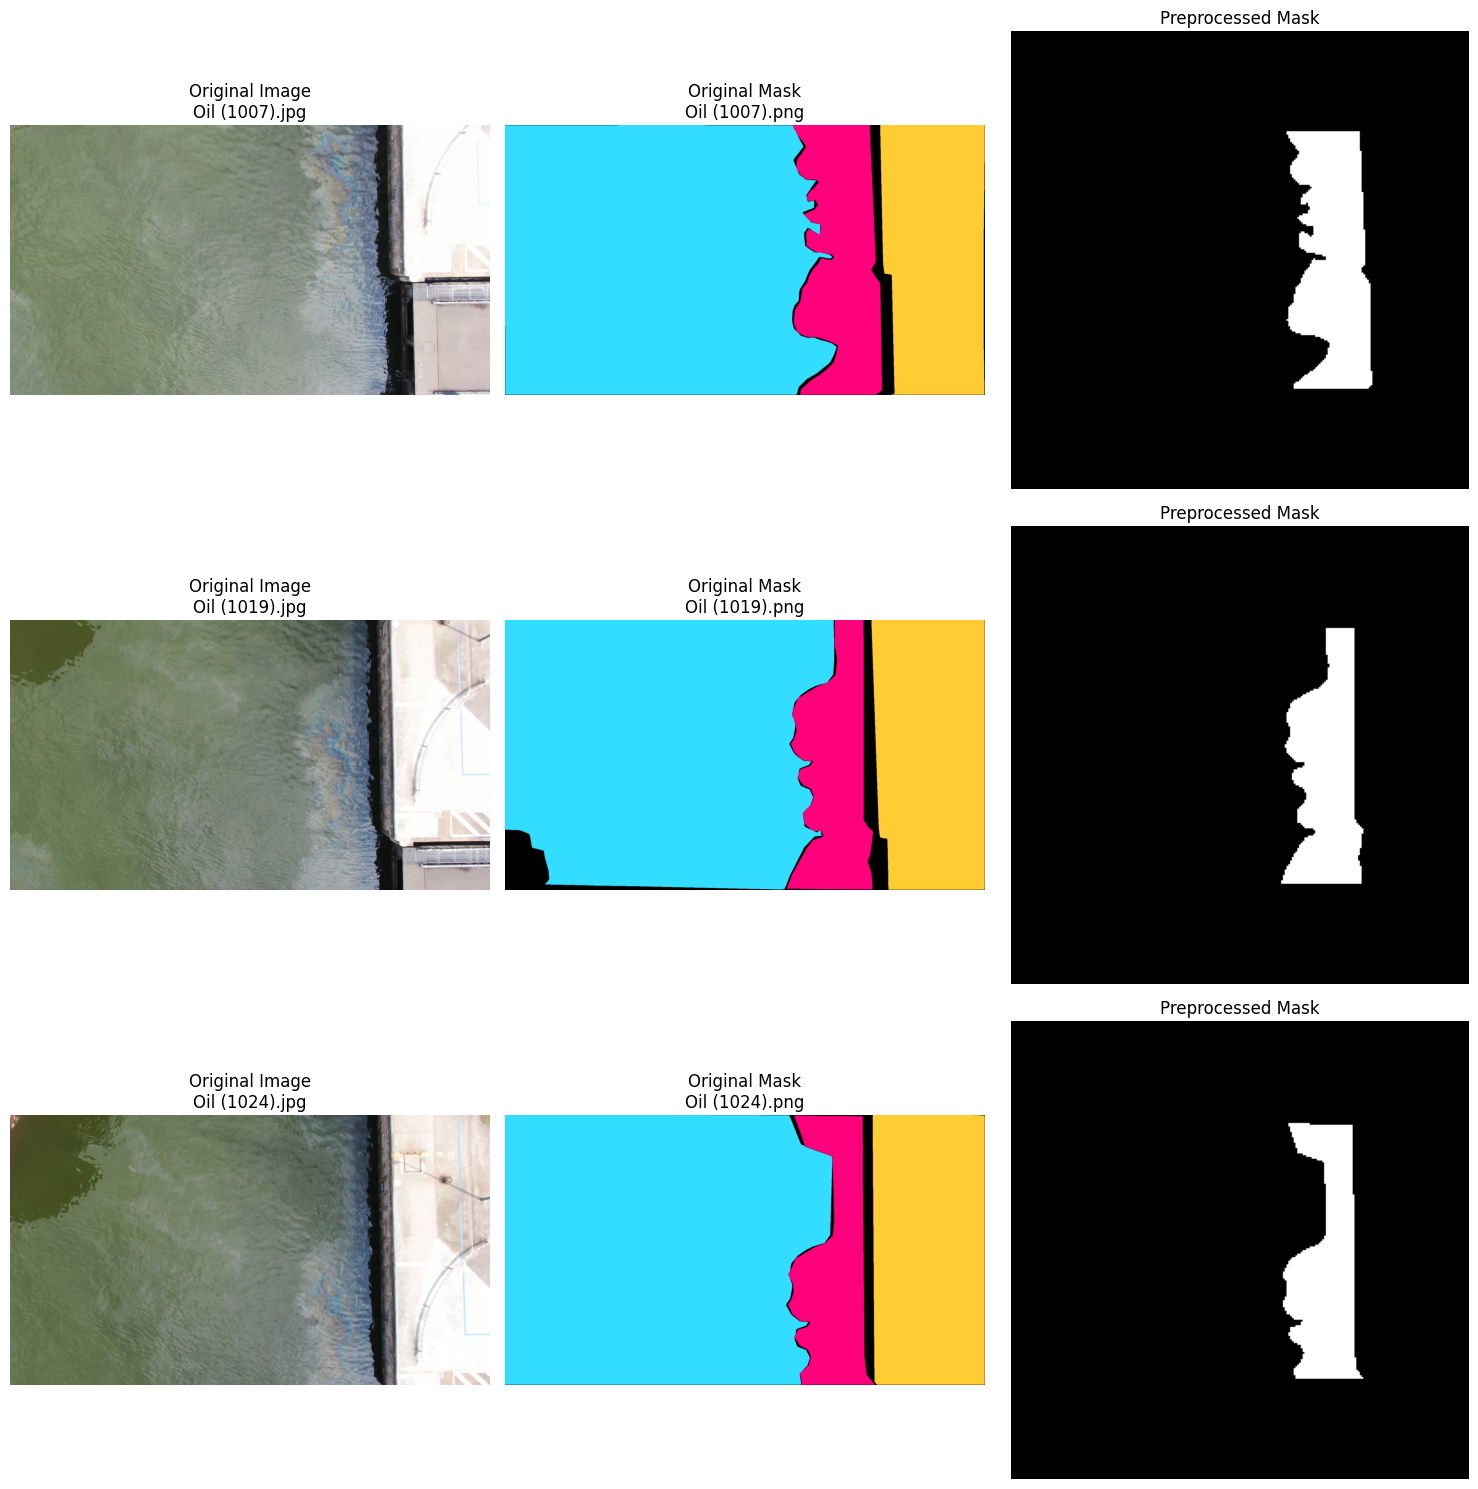


Starting dataset preprocessing and saving...
Found 833 images in train set


Processing train: 100%|██████████| 833/833 [06:33<00:00,  2.12it/s]


Saved 1666 train samples to /content/drive/MyDrive/preprocessed_dataset
Found 203 images in val set


Processing val: 100%|██████████| 203/203 [00:43<00:00,  4.65it/s]


Saved 203 val samples to /content/drive/MyDrive/preprocessed_dataset
Found 254 images in test set


Processing test: 100%|██████████| 254/254 [00:53<00:00,  4.72it/s]


Saved 254 test samples to /content/drive/MyDrive/preprocessed_dataset
Metadata saved to /content/drive/MyDrive/preprocessed_dataset
Preprocessing complete! Data saved to /content/drive/MyDrive/preprocessed_dataset

Example of loading preprocessed data:
Loaded 1666 training images and 1666 masks
Image shape: (256, 256, 3), Mask shape: (256, 256)


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pickle
from datetime import datetime
import json

# Define label colors
LABEL_COLORS = {
    'background': [0, 0, 0],        # RGB: 0,0,0
    'oil': [255, 0, 124],           # RGB: 255,0,124
    'others': [255, 204, 51],       # RGB: 255,204,51
    'water': [51, 221, 255]         # RGB: 51,221,255
}

def is_oil_spill_mask(mask):
    """
    Check if a mask contains oil spill pixels (RGB: 255,0,124)
    """
    mask_np = np.array(mask)
    oil_pixels = np.all(mask_np == LABEL_COLORS['oil'], axis=-1)
    return np.any(oil_pixels)

def count_oil_pixels(mask):
    """
    Count the number of oil spill pixels in a mask
    """
    mask_np = np.array(mask)
    oil_pixels = np.all(mask_np == LABEL_COLORS['oil'], axis=-1)
    return np.sum(oil_pixels)

def find_matching_mask(image_filename, masks_path):
    """
    Find the corresponding mask file for a given image filename.
    Improved to handle the naming patterns in your dataset.
    """
    # Get the base name without extension
    base_name = os.path.splitext(image_filename)[0]

    # Handle different naming patterns in your dataset
    # Pattern 1: "Oil (1133) (1).jpg" -> "Oil (1133).png"
    if " (" in base_name and ")" in base_name:
        # Extract the main part before the parenthesis with number
        main_part = base_name.split(" (")[0] + " (" + base_name.split(" (")[1].split(")")[0] + ")"
        possible_mask_names = [f"{main_part}.png"]
    else:
        possible_mask_names = [f"{base_name}.png"]

    # Also try the exact same filename with .png extension
    possible_mask_names.append(f"{base_name}.png")

    # Try all possible mask names
    for mask_name in possible_mask_names:
        mask_path = os.path.join(masks_path, mask_name)
        if os.path.exists(mask_path):
            return mask_name

    # If no mask found, try to find any file with similar base name
    all_mask_files = os.listdir(masks_path)
    for mask_file in all_mask_files:
        if base_name.split(" (")[0] in mask_file:
            return mask_file

    return None

def preprocess_image(image, target_size=(256, 256)):
    """
    Preprocess image: resize, normalize
    """
    if image is None:
        return np.zeros((*target_size, 3), dtype=np.float32)

    # Resize while maintaining aspect ratio with padding
    h, w = image.shape[:2]
    scale = min(target_size[0] / h, target_size[1] / w)
    new_h, new_w = int(h * scale), int(w * scale)

    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Create a black canvas of target size
    processed = np.zeros((target_size[0], target_size[1], 3), dtype=np.float32)

    # Calculate padding
    pad_top = (target_size[0] - new_h) // 2
    pad_left = (target_size[1] - new_w) // 2

    # Place the resized image in the center
    processed[pad_top:pad_top+new_h, pad_left:pad_left+new_w] = resized

    # Normalize to [0, 1]
    processed = processed.astype('float32') / 255.0

    return processed, (pad_top, pad_left, new_h, new_w)

def convert_mask_to_binary(mask):
    """
    Convert RGB mask to binary mask where oil pixels are 1 and others are 0
    """
    if mask is None:
        return np.zeros((256, 256), dtype=np.uint8)

    # Convert to numpy array if not already
    mask_np = np.array(mask)

    # Create binary mask where oil pixels are 1 and others are 0
    oil_pixels = np.all(mask_np == LABEL_COLORS['oil'], axis=-1)
    binary_mask = oil_pixels.astype(np.uint8)

    return binary_mask

def preprocess_mask(mask, target_size=(256, 256), padding_info=None):
    """
    Preprocess mask: resize and convert to appropriate format
    """
    if mask is None:
        return np.zeros(target_size, dtype=np.uint8)

    # Convert to binary first
    binary_mask = convert_mask_to_binary(mask)

    if padding_info:
        # Use the same padding as the corresponding image
        pad_top, pad_left, new_h, new_w = padding_info

        # Resize the binary mask
        resized_mask = cv2.resize(binary_mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

        # Create a black canvas of target size
        processed_mask = np.zeros(target_size, dtype=np.uint8)

        # Place the resized mask in the center
        processed_mask[pad_top:pad_top+new_h, pad_left:pad_left+new_w] = resized_mask
    else:
        # Simple resize without maintaining aspect ratio
        processed_mask = cv2.resize(binary_mask, target_size, interpolation=cv2.INTER_NEAREST)

    return processed_mask

def augment_image_and_mask(image, mask, rotation_range=0, horizontal_flip=False,
                          vertical_flip=False, brightness_range=(1.0, 1.0),
                          contrast_range=(1.0, 1.0)):
    """
    Apply data augmentation to both image and mask simultaneously with configurable parameters
    """
    # Make copies to avoid modifying original arrays
    image = image.copy()
    mask = mask.copy()

    # Rotation augmentation
    if rotation_range > 0:
        angle = np.random.uniform(-rotation_range, rotation_range)
        h, w = image.shape[:2]
        center = (w // 2, h // 2)

        M = cv2.getRotationMatrix2D(center, angle, 1.0)

        image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
        mask = cv2.warpAffine(mask, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT)

    # Horizontal flip
    if horizontal_flip and np.random.random() > 0.5:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    # Vertical flip
    if vertical_flip and np.random.random() > 0.5:
        image = cv2.flip(image, 0)
        mask = cv2.flip(mask, 0)

    # Brightness adjustment (only for images, not masks)
    if brightness_range[0] != 1.0 or brightness_range[1] != 1.0:
        brightness_factor = np.random.uniform(brightness_range[0], brightness_range[1])
        if image.dtype == np.float32:
            image = np.clip(image * brightness_factor, 0, 1)
        else:
            image = np.clip(image.astype(np.float32) * brightness_factor, 0, 255).astype(np.uint8)

    # Contrast adjustment (only for images, not masks)
    if contrast_range[0] != 1.0 or contrast_range[1] != 1.0:
        contrast_factor = np.random.uniform(contrast_range[0], contrast_range[1])
        if image.dtype == np.float32:
            mean = np.mean(image)
            image = np.clip((image - mean) * contrast_factor + mean, 0, 1)
        else:
            mean = np.mean(image.astype(np.float32))
            image = np.clip((image.astype(np.float32) - mean) * contrast_factor + mean, 0, 255).astype(np.uint8)

    return image, mask

def save_preprocessed_data(images, masks, output_dir, split_name):
    """
    Save preprocessed images and masks to specified directory
    """
    # Create output directories
    images_dir = os.path.join(output_dir, split_name, 'images')
    masks_dir = os.path.join(output_dir, split_name, 'masks')

    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(masks_dir, exist_ok=True)

    # Save each image and mask
    for i, (image, mask) in enumerate(zip(images, masks)):
        # Save image
        image_filename = f"{split_name}_image_{i:04d}.png"
        image_path = os.path.join(images_dir, image_filename)

        # Convert float image to uint8 for saving
        if image.dtype == np.float32:
            image_to_save = (image * 255).astype(np.uint8)
        else:
            image_to_save = image

        cv2.imwrite(image_path, cv2.cvtColor(image_to_save, cv2.COLOR_RGB2BGR))

        # Save mask
        mask_filename = f"{split_name}_mask_{i:04d}.png"
        mask_path = os.path.join(masks_dir, mask_filename)

        # Convert mask to appropriate format for saving
        cv2.imwrite(mask_path, mask * 255)  # Scale binary mask (0,1) to (0,255)

    print(f"Saved {len(images)} {split_name} samples to {output_dir}")

def save_metadata(metadata, output_dir):
    """
    Save preprocessing metadata for future reference
    """
    metadata_path = os.path.join(output_dir, 'preprocessing_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)

    print(f"Metadata saved to {output_dir}")

def preprocess_and_save_dataset(base_path, output_path, target_size=(256, 256),
                               augmentation_config=None):
    """
    Preprocess entire dataset and save for future use
    """
    splits = ['train', 'val', 'test']
    metadata = {
        'target_size': target_size,
        'preprocessing_date': str(datetime.now()),
        'augmentation_config': augmentation_config or {},
        'splits': {}
    }

    for split in splits:
        split_path = os.path.join(base_path, split)
        if not os.path.exists(split_path):
            print(f"Warning: {split} directory not found!")
            continue

        images_path = os.path.join(split_path, 'images')
        masks_path = os.path.join(split_path, 'masks')

        if not os.path.exists(images_path) or not os.path.exists(masks_path):
            print(f"Warning: images or masks directory not found in {split}!")
            continue

        image_files = sorted([f for f in os.listdir(images_path)
                            if f.endswith(('.png', '.jpg', '.jpeg'))])

        print(f"Found {len(image_files)} images in {split} set")

        preprocessed_images = []
        preprocessed_masks = []
        missing_masks = []

        for img_file in tqdm(image_files, desc=f"Processing {split}"):
            # Load image
            img_path = os.path.join(images_path, img_file)
            image = cv2.imread(img_path)
            if image is None:
                print(f"Warning: Could not load image {img_path}")
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Find and load mask
            mask_name = find_matching_mask(img_file, masks_path)
            if mask_name is None:
                missing_masks.append(img_file)
                continue

            mask_path = os.path.join(masks_path, mask_name)
            mask = cv2.imread(mask_path)
            if mask is None:
                print(f"Warning: Could not load mask {mask_path}")
                missing_masks.append(img_file)
                continue
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

            # Preprocess image and get padding info
            preprocessed_img, padding_info = preprocess_image(image, target_size)

            # Preprocess mask using the same padding info
            preprocessed_mask = preprocess_mask(mask, target_size, padding_info)

            preprocessed_images.append(preprocessed_img)
            preprocessed_masks.append(preprocessed_mask)

            # Apply augmentation for training set
            if split == 'train' and augmentation_config:
                augmented_img, augmented_mask = augment_image_and_mask(
                    image, mask, **augmentation_config
                )
                augmented_img_processed, aug_padding_info = preprocess_image(augmented_img, target_size)
                augmented_mask_processed = preprocess_mask(augmented_mask, target_size, aug_padding_info)

                preprocessed_images.append(augmented_img_processed)
                preprocessed_masks.append(augmented_mask_processed)

        # Save preprocessed data
        save_preprocessed_data(preprocessed_images, preprocessed_masks, output_path, split)

        # Update metadata
        metadata['splits'][split] = {
            'original_images': len(image_files),
            'processed_samples': len(preprocessed_images),
            'missing_masks': len(missing_masks),
            'missing_mask_files': missing_masks
        }

        if missing_masks:
            print(f"Warning: Could not find masks for {len(missing_masks)} images in {split} set")

    # Save metadata
    save_metadata(metadata, output_path)
    print(f"Preprocessing complete! Data saved to {output_path}")

def load_preprocessed_data(data_dir, split_name):
    """
    Load preprocessed images and masks from directory
    """
    images_dir = os.path.join(data_dir, split_name, 'images')
    masks_dir = os.path.join(data_dir, split_name, 'masks')

    if not os.path.exists(images_dir) or not os.path.exists(masks_dir):
        raise ValueError(f"Preprocessed data not found for {split_name}")

    # Get sorted lists of files
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.png')])
    mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith('.png')])

    images = []
    masks = []

    for img_file, mask_file in zip(image_files, mask_files):
        # Load image
        img_path = os.path.join(images_dir, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32) / 255.0  # Normalize

        # Load mask
        mask_path = os.path.join(masks_dir, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = mask.astype(np.float32) / 255.0  # Normalize to 0-1

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

def analyze_dataset_balance(base_path):
    """
    Analyze the dataset to determine class balance across train, val, and test splits
    """
    splits = ['train', 'val', 'test']
    results = {}

    for split in splits:
        split_path = os.path.join(base_path, split)
        if not os.path.exists(split_path):
            print(f"Warning: {split} directory not found!")
            continue

        masks_path = os.path.join(split_path, 'masks')

        if not os.path.exists(masks_path):
            print(f"Warning: masks directory not found in {split}!")
            continue

        mask_files = sorted([f for f in os.listdir(masks_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

        print(f"Found {len(mask_files)} masks in {split} set")

        positive_count = 0
        negative_count = 0
        total_pixels = 0
        spill_pixels = 0

        for mask_name in tqdm(mask_files, desc=f"Processing {split} masks"):
            mask_path = os.path.join(masks_path, mask_name)
            mask = cv2.imread(mask_path)
            if mask is None:
                print(f"Warning: Could not load mask {mask_path}")
                continue

            mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

            if is_oil_spill_mask(mask_rgb):
                positive_count += 1
                spill_pixels += count_oil_pixels(mask_rgb)
            else:
                negative_count += 1

            total_pixels += mask_rgb.shape[0] * mask_rgb.shape[1]

        total_samples = positive_count + negative_count
        if total_samples > 0:
            positive_ratio = positive_count / total_samples
            negative_ratio = negative_count / total_samples
        else:
            positive_ratio = negative_ratio = 0

        if total_pixels > 0:
            spill_pixel_ratio = spill_pixels / total_pixels
        else:
            spill_pixel_ratio = 0

        results[split] = {
            'total_samples': total_samples,
            'positive_count': positive_count,
            'negative_count': negative_count,
            'positive_ratio': positive_ratio,
            'negative_ratio': negative_ratio,
            'spill_pixels': spill_pixels,
            'total_pixels': total_pixels,
            'spill_pixel_ratio': spill_pixel_ratio
        }

    return results

def verify_mask_loading(base_path):
    """
    Verify that we're correctly reading and interpreting the masks
    """
    print("VERIFYING MASK LOADING:")
    print("=" * 40)

    splits = ['train', 'val', 'test']
    masks_path = None

    for split in splits:
        split_masks_path = os.path.join(base_path, split, 'masks')
        if os.path.exists(split_masks_path):
            masks_path = split_masks_path
            break

    if not masks_path:
        print("Could not find any masks directory!")
        return

    mask_files = [f for f in os.listdir(masks_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    if not mask_files:
        print("No mask files found!")
        return

    print(f"Analyzing {min(3, len(mask_files))} sample masks from {masks_path}:")

    for i, mask_file in enumerate(mask_files[:3]):
        mask_path = os.path.join(masks_path, mask_file)
        mask = cv2.imread(mask_path)

        if mask is None:
            print(f"❌ Could not load mask: {mask_file}")
            continue

        mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        print(f"\n📊 Mask {i+1}: {mask_file}")
        print(f"   Shape: {mask_rgb.shape}")
        print(f"   Data type: {mask_rgb.dtype}")

        for class_name, color in LABEL_COLORS.items():
            class_pixels = np.all(mask_rgb == color, axis=-1)
            count = np.sum(class_pixels)
            percentage = count / (mask_rgb.shape[0] * mask_rgb.shape[1]) * 100
            print(f"   {class_name}: {count} pixels ({percentage:.2f}%)")

        oil_pixels = np.all(mask_rgb == LABEL_COLORS['oil'], axis=-1)
        if np.any(oil_pixels):
            print("   ✅ This contains OIL SPILL pixels")
        else:
            print("   🚫 This does NOT contain oil spill pixels")

def visualize_sample_images(dataset_path, num_samples=3):
    """
    Visualize original images, their masks, and preprocessed versions
    """
    splits = ['train', 'val', 'test']

    for split in splits:
        split_path = os.path.join(dataset_path, split)
        if not os.path.exists(split_path):
            print(f"Skipping {split} - directory not found")
            continue

        images_path = os.path.join(split_path, 'images')
        masks_path = os.path.join(split_path, 'masks')

        if not os.path.exists(images_path) or not os.path.exists(masks_path):
            print(f"Skipping {split} - images or masks directory not found")
            continue

        image_files = sorted([f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

        if not image_files:
            print(f"No image files found in {split}")
            continue

        print(f"\nVisualizing {min(num_samples, len(image_files))} samples from {split} set:")

        # Create figure for visualization
        fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
        if num_samples == 1:
            axes = axes.reshape(1, -1)

        samples_processed = 0
        for i in range(min(num_samples, len(image_files))):
            # Load original image and mask
            img_path = os.path.join(images_path, image_files[i])

            # Load image with error handling
            original_img = cv2.imread(img_path)
            if original_img is None:
                print(f"Warning: Could not load image {img_path}")
                continue
            original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

            # Find matching mask
            mask_name = find_matching_mask(image_files[i], masks_path)
            if mask_name is None:
                print(f"Warning: Could not find mask for {image_files[i]}")
                continue

            mask_path = os.path.join(masks_path, mask_name)

            # Load mask with error handling
            original_mask = cv2.imread(mask_path)
            if original_mask is None:
                print(f"Warning: Could not load mask {mask_path}")
                continue
            original_mask = cv2.cvtColor(original_mask, cv2.COLOR_BGR2RGB)

            # Preprocess image and mask
            preprocessed_img, padding_info = preprocess_image(original_img)
            preprocessed_mask = preprocess_mask(original_mask, padding_info=padding_info)

            # Plot original image
            axes[samples_processed, 0].imshow(original_img)
            axes[samples_processed, 0].set_title(f"Original Image\n{image_files[i]}")
            axes[samples_processed, 0].axis('off')

            # Plot original mask
            axes[samples_processed, 1].imshow(original_mask)
            axes[samples_processed, 1].set_title(f"Original Mask\n{mask_name}")
            axes[samples_processed, 1].axis('off')

            # Plot preprocessed mask
            axes[samples_processed, 2].imshow(preprocessed_mask, cmap='gray')
            axes[samples_processed, 2].set_title(f"Preprocessed Mask")
            axes[samples_processed, 2].axis('off')

            samples_processed += 1

        # Remove empty subplots if we couldn't load all samples
        if samples_processed < num_samples:
            for j in range(samples_processed, num_samples):
                for k in range(3):
                    axes[j, k].set_visible(False)

        plt.tight_layout()
        plt.show()

def document_preprocessing_techniques():
    """
    Document the preprocessing techniques used for oil spill images
    """
    print("=" * 80)
    print("OIL SPILL IMAGE PREPROCESSING TECHNIQUES")
    print("=" * 80)

    print("\n1. RESIZING:")
    print("   - All images are resized to 256x256 pixels")
    print("   - Maintains aspect ratio with appropriate padding if needed")
    print("   - Reduces computational requirements while preserving important features")

    print("\n2. NORMALIZATION:")
    print("   - Pixel values are scaled to the range [0, 1]")
    print("   - Formula: normalized_pixel = original_pixel / 255.0")
    print("   - Helps with model convergence during training")

    print("\n3. DATA AUGMENTATION:")
    print("   - Applied to both images and masks simultaneously")
    print("   - Techniques include:")
    print("     * Random rotation")
    print("     * Horizontal and vertical flipping")
    print("     * Brightness adjustment")
    print("     * Contrast adjustment")
    print("   - Masks are augmented consistently with images")

    print("\n4. MASK PROCESSING:")
    print("   - RGB masks are converted to binary format")
    print("   - Oil spill pixels (RGB: 255,0,124) become 1")
    print("   - All other pixels become 0")
    print("   - Resized to match image dimensions (256x256)")

    print("\n5. DATA SAVING:")
    print("   - Preprocessed images and masks are saved as PNG files")
    print("   - Organized in train/val/test directories")
    print("   - Metadata is saved for reproducibility")

    print("\n" + "=" * 80)

# Example usage
if __name__ == "__main__":
    # Set the path to your dataset directory
    dataset_path = '/content/drive/MyDrive/dataset'
    output_path = '/content/drive/MyDrive/preprocessed_dataset'

    if not os.path.exists(dataset_path):
        print(f"Error: Path {dataset_path} does not exist!")
    else:
        # Document preprocessing techniques
        document_preprocessing_techniques()

        # Verify mask loading
        verify_mask_loading(dataset_path)

        # Analyze dataset balance
        results = analyze_dataset_balance(dataset_path)

        # Visualize sample images
        visualize_sample_images(dataset_path, num_samples=3)

        # Define augmentation configuration
        augmentation_config = {
            'rotation_range': 15,
            'horizontal_flip': True,
            'vertical_flip': True,
            'brightness_range': (0.8, 1.2),
            'contrast_range': (0.8, 1.2)
        }

        # Preprocess and save the entire dataset
        print("\nStarting dataset preprocessing and saving...")
        preprocess_and_save_dataset(
            base_path=dataset_path,
            output_path=output_path,
            target_size=(256, 256),
            augmentation_config=augmentation_config
        )

        # Example of how to load preprocessed data
        print("\nExample of loading preprocessed data:")
        try:
            train_images, train_masks = load_preprocessed_data(output_path, 'train')
            print(f"Loaded {len(train_images)} training images and {len(train_masks)} masks")
            if len(train_images) > 0:
                print(f"Image shape: {train_images[0].shape}, Mask shape: {train_masks[0].shape}")
        except Exception as e:
            print(f"Error loading preprocessed data: {e}")